# Lattice parameter assessment using ANN extracted features via linear regression

## 1. Data preparation

In [1]:
import numpy as np
import pandas as pd
import keras.models as models
import keras
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import copy
import matplotlib.pyplot as plt
import matplotlib.colors

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.size'] = 15
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (7.2,4.45)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The dataframe used to create the collection to train the ANN is loaded. 
The ANN 6S10O_WD is loaded.

In [2]:
df = pd.read_pickle('red_cod-db-lat.pkl')
modelo = models.load_model('6S10O_WEF.h5')

The compounds of the TRAining - VALidation (TRAVAL) set and TEST set are loaded, with their features needed by 6S10O_WD

In [3]:
db0 = pd.read_csv('dbtraval.csv')
x0 = np.load('Xtraval.npy')

db1 = pd.read_csv('dbtest.csv')
x1 = np.load('Xtest.npy')

db = db0.append(db1, ignore_index=True)
xor = np.concatenate((x0, x1))

The dictionary to standarize the features is loaded. The features are standarized aftwerward.

In [4]:
diccio = np.load('6S10O_WEF-diccio.npy').item()
xstr = (x0 - diccio['mean'])/diccio['std']
xsts = (x1 - diccio['mean'])/diccio['std']

The features containing the local functions and the density of the compound are turned off.

In [5]:
xstr[:,:,132:] = 0
xsts[:,:,132:] = 0

The ANN 6S10O_WEF is croped till the hidden layer in the middle (the second one). The ANN was croped before activation with tanh function.

In [6]:
croped_model = keras.Model(inputs = modelo.input,
                           outputs = modelo.get_layer(index=4).output)

Now, the extracted features by the ANN 6S10O_WEF are computed.

In [7]:
xhtr = croped_model.predict(xstr[:,0,:])
xhts = croped_model.predict(xsts[:,0,:])

The lattice parameter, unit vectors and their angles, of the compounds of TRAVAL and TEST sets are search in the dataframe df.

In [8]:
lp_tr = np.zeros((db0.shape[0],6))
lp_ts = np.zeros((db1.shape[0],6))

for row in range(db0.shape[0]):
    lp_tr[row] = df[df['cif'] == db0['cif'][row]][['a','b','c','alfa','beta','gamma']].values

for row in range(db1.shape[0]):
    lp_ts[row] = df[df['cif'] == db1['cif'][row]][['a','b','c','alfa','beta','gamma']].values


Next function looks for the compound of a given crystal structure (target) and spacegroup. After identifying the target compounds, the function retrieves the X and Y sets for linear regression.

In [9]:
def take_compounds(x = np.ones((1,1)), y = np.ones((1,1)),
                   db = pd.DataFrame(), sgnum = 221, target = 7):
    sidx = db[db['sgnum'] == sgnum][db['target'] == target].index
    
    return x[sidx], y[sidx], db.take(sidx).reset_index(drop=True)

## 2. Lattice parameter - linear regression of cubic crystal structures

Now, the sets X and Y are created for the compounds with the crystal structures garnet, spinel, cubic single perovskite (space group 221), and cubic double perovskites (space group 225).

In [10]:
xtr_per221, ytr_per221, dbtr_per221 = take_compounds(x=xhtr, y = lp_tr[:,0], db = db0, sgnum=221, target=7)
xts_per221, yts_per221, dbts_per221 = take_compounds(x=xhts, y = lp_ts[:,0], db = db1, sgnum=221, target=7)

xtr_per225, ytr_per225, dbtr_per225 = take_compounds(x=xhtr, y = lp_tr[:,0], db = db0, sgnum=225, target=7)
xts_per225, yts_per225, dbts_per225 = take_compounds(x=xhts, y = lp_ts[:,0], db = db1, sgnum=225, target=7)

xtr_garnet, ytr_garnet, dbtr_garnet = take_compounds(x=xhtr, y = lp_tr[:,0], db = db0, sgnum=230, target=1)
xts_garnet, yts_garnet, dbts_garnet = take_compounds(x=xhts, y = lp_ts[:,0], db = db1, sgnum=230, target=1)

xtr_spinel, ytr_spinel, dbtr_spinel = take_compounds(x=xhtr, y = lp_tr[:,0], db = db0, sgnum=227, target=8)
xts_spinel, yts_spinel, dbts_spinel = take_compounds(x=xhts, y = lp_ts[:,0], db = db1, sgnum=227, target=8)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Next, linear regression is performed with the X and Y sets of each crystal structure type.

In [11]:
reg_per221 = LinearRegression().fit(xtr_per221, ytr_per221)
reg_per225 = LinearRegression().fit(xtr_per225, ytr_per225)
reg_garnet = LinearRegression().fit(xtr_garnet, ytr_garnet)
reg_spinel = LinearRegression().fit(xtr_spinel, ytr_spinel)

The next function prints r2 - score, mean square error (mse), and the lattice parameters assessed by the linear regression.

In [12]:
def use_regressor(regressor = LinearRegression(), 
                  xtr = np.ones((1,1)), 
                  ytr = np.ones((1,1)),
                  xts = np.ones((1,1)),
                  yts = np.ones((1,1)),
                  tol = 0):
    
    ptr = regressor.predict(xtr)
    pts = regressor.predict(xts)
        
    if tol:
        try:
            if yts.shape[1]:
                touse = [i for i in range(pts.shape[0]) if mse(pts[i], yts[i]) <= tol]
                unit_vectors = yts.shape[1]
            
        except:
            touse = [i for i in range(pts.shape[0]) if abs(pts - yts)[i] <= tol]
            unit_vectors = 1
        print(len(touse), 'samples of the test set are used instead of', yts.shape[0])
        print('There were ', yts.shape[0] - len(touse), 'outliers.')
    else:
        touse = range(yts.shape[0])
    
    r2 = regressor.score(xtr, ytr)    
    
    mse_train = mse(ytr, ptr)
    mse_test = mse(yts[touse], pts[touse])
    
    print('r2:', r2)
    print('mse_train:', mse_train)
    print('mse_test:', mse_test)
    #'''
    print('number of samples in fitting/test:', ytr.shape[0],'/', yts.shape[0])
    print('Mean value in fitting/test:', ytr.mean(axis=0),'/', yts.mean(axis=0))
    print('Std value in fitting/test:', ytr.std(axis=0),'/', yts.std(axis=0))
    #'''
    if unit_vectors > 1:
        for dim in range(yts.shape[1]):
            plt.figure(dim)
            plt.title('Lattice parameter linear regression')
            plt.scatter(ytr[:,dim], ptr[:,dim], color='blue', marker='o')
            plt.scatter(yts[touse][:,dim], pts[touse][:,dim], color='red', marker='o')
            plt.xlabel('actual lattice parameter in angstroms')
            plt.ylabel('assessed lattice parameter in angstroms')
            plt.show()
    else:
        plt.figure()
        plt.title('Lattice parameter linear regression')
        plt.scatter(ytr, ptr, color='blue', marker='o')
        plt.scatter(yts[touse], pts[touse], color='red', marker='o')
        plt.xlabel('actual lattice parameter in angstroms')
        plt.ylabel('assessed lattice parameter in angstroms')
        plt.show()
    
    return ptr, pts
    

LR with garnets
23 samples of the test set are used instead of 28
There were  5 outliers.
r2: 0.9997744009982619
mse_train: 3.0126203492329465e-05
mse_test: 0.09307038912957545
number of samples in fitting/test: 165 / 28
Mean value in fitting/test: 12.080768957575758 / 12.013840821428571
Std value in fitting/test: 0.365429510228275 / 0.34096343584896666


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


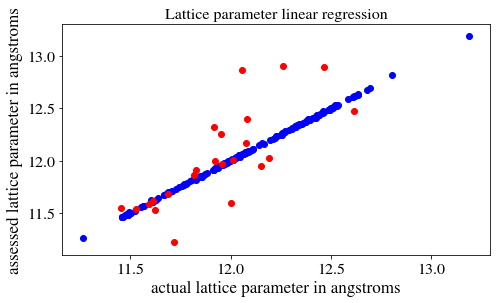

LR with spinels
107 samples of the test set are used instead of 127
There were  20 outliers.
r2: 0.9682356466256131
mse_train: 0.025592108086692975
mse_test: 0.06757470998303247
number of samples in fitting/test: 714 / 127
Mean value in fitting/test: 8.699791733893557 / 8.578858740157479
Std value in fitting/test: 0.8976003664697172 / 0.7576718180046113


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


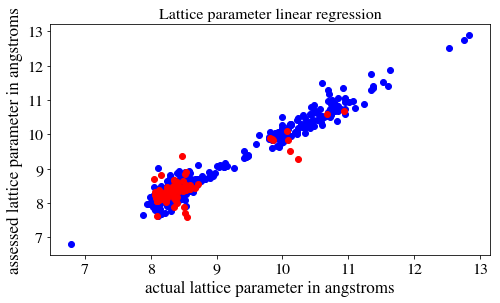

LR with single cubic perovskites
39 samples of the test set are used instead of 54
There were  15 outliers.
r2: 0.9995960862958758
mse_train: 7.519411543806956e-05
mse_test: 0.10565118616583594
number of samples in fitting/test: 344 / 54
Mean value in fitting/test: 4.169820555232558 / 4.169348944444445
Std value in fitting/test: 0.4314670478549094 / 0.3571069794641593


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


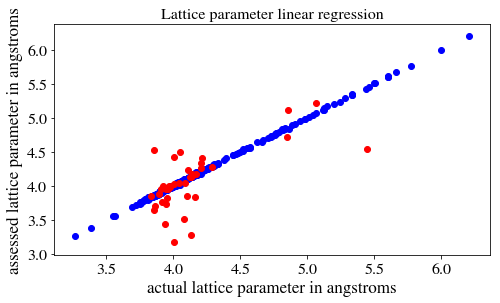

LR with double cubic perovskites
23 samples of the test set are used instead of 33
There were  10 outliers.
r2: 0.9991633516611496
mse_train: 0.00023588426811401402
mse_test: 0.09838428234858486
number of samples in fitting/test: 205 / 33
Mean value in fitting/test: 8.480694897560975 / 8.590612696969698
Std value in fitting/test: 0.5309798153258901 / 0.7389780432773967


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


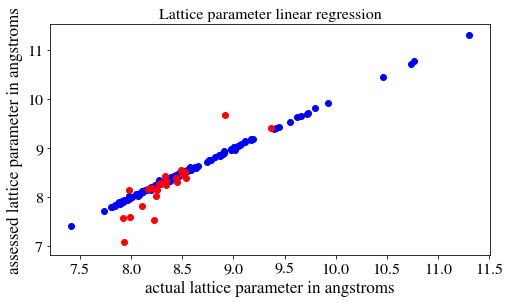

In [13]:
print('LR with garnets')
ptr_garnet, pts_garnet = use_regressor(regressor=reg_garnet, 
              xtr=xtr_garnet, ytr = ytr_garnet,
              xts=xts_garnet, yts = yts_garnet, tol=1)
print('LR with spinels')
ptr_spinel, pts_spinel = use_regressor(regressor=reg_spinel, 
              xtr=xtr_spinel, ytr = ytr_spinel,
              xts=xts_spinel, yts = yts_spinel, tol=1)
print('LR with single cubic perovskites')
ptr_per221, pts_per221 = use_regressor(regressor=reg_per221, 
              xtr=xtr_per221, ytr = ytr_per221,
              xts=xts_per221, yts = yts_per221, tol=1)
print('LR with double cubic perovskites')
ptr_per225, pts_per225 = use_regressor(regressor=reg_per225, 
              xtr=xtr_per225, ytr = ytr_per225,
              xts=xts_per225, yts = yts_per225, tol=1)

## 3. Lattice parameter - linear regression of orthorhombic perovskites

The sets X and Y are created using orthorhombic perovskite structures with the space group No. 62

In [14]:
xtr_perort, ytr_perort, dbtr_perort = take_compounds(x=xhtr, y = lp_tr[:,0:3], db = db0, sgnum=62, target=7)
xts_perort, yts_perort, dbts_perort = take_compounds(x=xhts, y = lp_ts[:,0:3], db = db1, sgnum=62, target=7)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Now, the lattice parameter are sorted in increasing fashion.

In [15]:
ytr_perort = np.sort(ytr_perort, axis=1)
yts_perort = np.sort(yts_perort, axis=1)

In [16]:
reg_perort = LinearRegression().fit(xtr_perort, ytr_perort)

70 samples of the test set are used instead of 87
There were  17 outliers.
r2: 0.9836493067554262
mse_train: 0.003489565303786192
mse_test: 0.06833179654319103
number of samples in fitting/test: 388 / 87
Mean value in fitting/test: [5.51481557 5.64328312 7.82911853] / [5.48335276 5.62001425 7.76325471]
Std value in fitting/test: [0.3833935  0.40446723 0.56591373] / [0.23841727 0.27964642 0.41561341]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


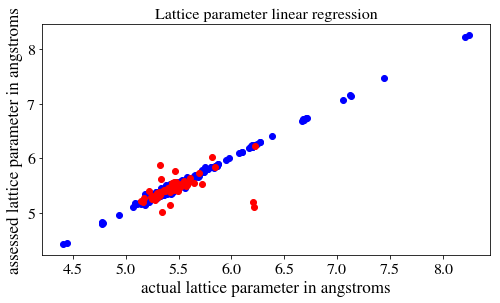

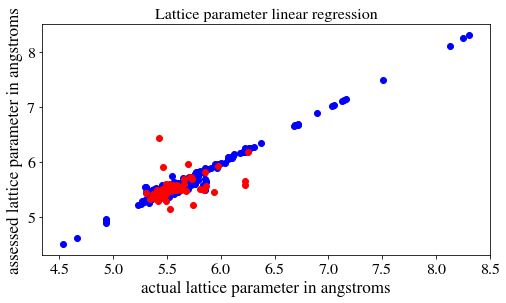

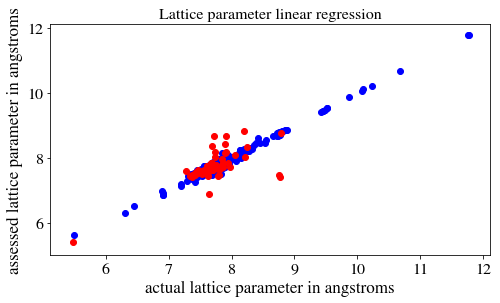

In [17]:
ptr_perort, pts_perort = use_regressor(regressor=reg_perort, 
              xtr=xtr_perort, ytr = ytr_perort,
              xts=xts_perort, yts = yts_perort, tol=1.5)

## 4. Lattice parameter - linear regression of trigonal perovskites

The sets X and Y are created using trigonal perovskite structures with the space group No. 167

In [18]:
xtr_perrhom, ytr_perrhom, dbtr_perrhom = take_compounds(x=xhtr, y = lp_tr[:,0:3], db = db0, sgnum=167, target=7)
xts_perrhom, yts_perrhom, dbts_perrhom = take_compounds(x=xhts, y = lp_ts[:,0:3], db = db1, sgnum=167, target=7)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Now, the lattice parameter are sorted in increasing fashion.

In [19]:
ytr_perrhom = np.sort(ytr_perrhom, axis=1)[:,[0,2]]
yts_perrhom = np.sort(yts_perrhom, axis=1)[:,[0,2]]

Due to the symmetry of the unit cell, the linear regression is only performed to two unit vectors, a and c.

In [20]:
reg_perrhom = LinearRegression().fit(xtr_perrhom, ytr_perrhom)

15 samples of the test set are used instead of 22
There were  7 outliers.
r2: 0.9993862107508358
mse_train: 0.00023752473808933832
mse_test: 0.029740450719513548
number of samples in fitting/test: 134 / 22
Mean value in fitting/test: [ 5.35479363 13.91182607] / [ 5.50700432 14.00411195]
Std value in fitting/test: [0.33506514 1.05554025] / [0.37618622 1.0438705 ]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


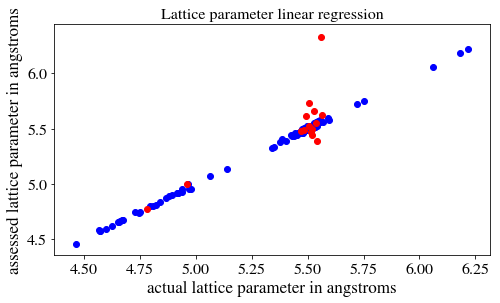

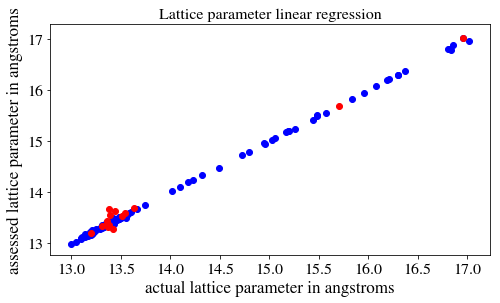

In [21]:
ptr_perrhom, pts_perrhom = use_regressor(regressor=reg_perrhom, 
              xtr=xtr_perrhom, ytr = ytr_perrhom,
              xts=xts_perrhom, yts = yts_perrhom, tol=1.5)

## 5. Lattice parameter - linear regression of Ruddlesden-Popper perovskites

The sets X and Y are created using tetragonal Ruddlesden-Popper structures with the space group No. 139

In [22]:
xtr_perlay, ytr_perlay, dbtr_perlay = take_compounds(x=xhtr, y = lp_tr[:,0:3], db = db0, sgnum=139, target=5)
xts_perlay, yts_perlay, dbts_perlay = take_compounds(x=xhts, y = lp_ts[:,0:3], db = db1, sgnum=139, target=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Now, the lattice parameter are sorted in increasing fashion.

In [23]:
ytr_perlay = np.sort(ytr_perlay, axis=1)[:,[0,2]]
yts_perlay = np.sort(yts_perlay, axis=1)[:,[0,2]]

Due to the symmetry of the unit cell, the linear regression is only performed to two unit vectors, a and c.

In [24]:
reg_perlay = LinearRegression().fit(xtr_perlay, ytr_perlay)

18 samples of the test set are used instead of 31
There were  13 outliers.
r2: 0.942207544784184
mse_train: 0.008512656373100124
mse_test: 0.06730762878273643
number of samples in fitting/test: 196 / 31
Mean value in fitting/test: [ 3.94336918 15.97456883] / [ 3.94740129 15.44098613]
Std value in fitting/test: [0.33400946 3.98512875] / [0.28581022 3.94454759]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


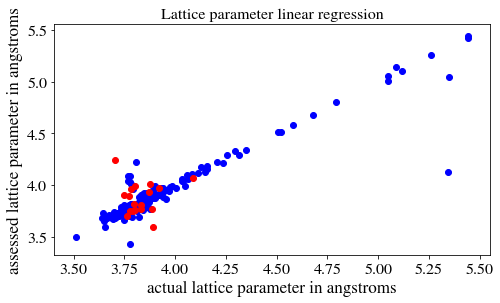

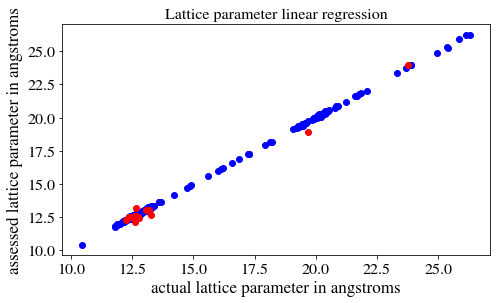

In [25]:
ptr_perlay, pts_perlay = use_regressor(regressor=reg_perlay, 
              xtr=xtr_perlay, ytr = ytr_perlay,
              xts=xts_perlay, yts = yts_perlay, tol=1)

In [26]:
def save_df(db=pd.DataFrame(), yact = np.ones((1,1)), pred =np.ones((1,1)),
           labels=list(), name='name'):
    db = db[['cif','formula','sgnum','sitios','elements', 'atoms']]
    try:
        print('There are', yact.shape[1], 'lattice parameters')
    except:
        yact = yact[:,np.newaxis]
        pred = pred[:, np.newaxis]
        
    for dim, label in zip(range(yact.shape[-1]),labels):
        db[label + '_actual'] = yact[:,dim]
        db[label + '_pred'] = pred[:,dim]
        
        db.to_csv(name + '.csv', index=None)
    return db


In [27]:
save_df(db=dbtr_per221, yact = ytr_per221, pred = ptr_per221, labels=['a'], name='dbtr_per221')
save_df(db=dbts_per221, yact = yts_per221, pred = pts_per221, labels=['a'], name='dbts_per221')

save_df(db=dbtr_per225, yact = ytr_per225, pred = ptr_per225, labels=['a'], name='dbtr_per225')
save_df(db=dbts_per225, yact = yts_per225, pred = pts_per225, labels=['a'], name='dbts_per225')

save_df(db=dbtr_garnet, yact = ytr_garnet, pred = ptr_garnet, labels=['a'], name='dbtr_garnet')
save_df(db=dbts_garnet, yact = yts_garnet, pred = pts_garnet, labels=['a'], name='dbts_garnet')

save_df(db=dbtr_spinel, yact = ytr_spinel, pred = ptr_spinel, labels=['a'], name='dbtr_spinel')
save_df(db=dbts_spinel, yact = yts_spinel, pred = pts_spinel, labels=['a'], name='dbts_spinel')

save_df(db=dbtr_perort, yact = ytr_perort, pred = ptr_perort, labels=['a','b','c'], name='dbtr_perort')
save_df(db=dbts_perort, yact = yts_perort, pred = pts_perort, labels=['a','b','c'], name='dbts_perort')

save_df(db=dbtr_perrhom, yact = ytr_perrhom, pred = ptr_perrhom, labels=['a','c'], name='dbtr_perrhom')
save_df(db=dbts_perrhom, yact = yts_perrhom, pred = pts_perrhom, labels=['a','c'], name='dbts_perrhom')

save_df(db=dbtr_perlay, yact = ytr_perlay, pred = ptr_perlay, labels=['a','c'], name='dbtr_perlay')
save_df(db=dbts_perlay, yact = yts_perlay, pred = pts_perlay, labels=['a','c'], name='dbts_perlay')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


There are 3 lattice parameters
There are 3 lattice parameters
There are 2 lattice parameters
There are 2 lattice parameters
There are 2 lattice parameters
There are 2 lattice parameters


,cif,formula,sgnum,sitios,elements,atoms,a_actual,a_pred,c_actual,c_pred
0,4002334,Sr3NdMn2O8,139,4,4.0,14.000,3.83110,3.765625,12.36850,12.515320
1,1526926,Sr0.3La3.7Cu1.4Ni0.6O8,139,4,5.0,14.000,3.80250,3.988403,13.06550,13.058044
2,2002185,Sr2Cu(BrO)2,139,4,4.0,14.000,3.99100,158.816895,17.13599,-81.590149
3,7221475,Ca4Sb2O,139,4,3.0,14.000,4.67700,421.679321,16.34200,64.833191
4,1533347,SrTb2Al2O7,139,6,4.0,24.000,3.70440,4.243530,19.67100,18.914978
5,1525679,D4Rb2Ca,139,4,3.0,14.000,4.49760,-10.627808,14.82940,-109.899353
6,1544432,NaLaTa2O7,139,6,4.0,22.000,3.89550,-25.885010,21.43600,61.585632
7,1529144,Sr6Fe2.28Co1.72Cl4O10,139,6,5.0,24.000,3.91932,3.976196,23.77820,23.944275
8,1509435,LaTa2AgO7,139,6,4.0,22.000,3.89400,-11.876465,21.56400,101.118835
9,1521810,Sr4Ir0.8Ru1.2O8,139,4,4.0,14.000,3.87800,4.013306,12.79600,12.427429
